In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)  # default tensor device
print("I'm using: ", device)

I'm using:  cpu
I'm using:  cpu


In [2]:
def convert(x):
    y = x
    return y.cpu().detach().numpy()

## Wave equation

Let $I=(0,4)$ and $T=3$. We want to use a PINN to approximate the solution to the PDE
$$
  \begin{cases}
    \displaystyle \frac{\partial^2 u}{\partial t^2}-2\frac{\partial^2 u}{\partial x^2}=0, & x\in I, \ \ t\in(0,T],\\[10pt]
    \displaystyle u(x,0)= 0 =: u_0(x), &x\in I, \\[10pt]
    \displaystyle \frac{\partial u}{\partial t}(x,0) =  \frac{\pi \sqrt2}{2}\sin \Big(\frac{\pi x}{2}\Big)=:u_1(x), &x\in I, \\[10pt]
    \displaystyle u(0,t)=u(4,t)=0, &t\in(0,T].
  \end{cases}
$$
set in the space-time cylinder $I \times(0, T]$.

Define a FNN with 3 layer, 50 neuron and $\tanh$ (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as the activation function. Note that in this case the NN has two-dimensional input.

In [3]:
input = 2
output = 1
hidden_layer = 3 * [50]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function, input, hidden_layer, output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=False)
)

Using `torch.random.uniform`, define the points that will be used for training. We want to define $4$ different sets of points:
- $1500$ points in the interior of the space-time cylinder $I\times (0, T)$
- $500$ points for the initial datum $u_0$ on the line $I\times \{0\}$
- $100$ points for the initial datum of the derivative $u_1$ on the line $I\times \{0\}$
- $200$ points ($100$ per "side") for the boundary conditions on $\partial I \times (0, T)$

Text(0.5, 1.0, 'Collocation Data')

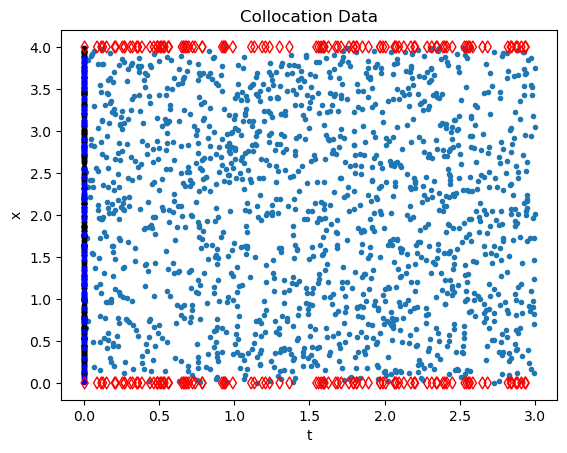

In [4]:
x_ini, x_fin = 0, 4
t_ini, t_fin = 0, 3

N_int = 1500  # number of collocation points
N_0 = 500  # collocation of the initial data
N_0t = 100  # collocation initial data derivate
N_b = 100  # collocation of the boundary coniditon

x_int = np.random.uniform(x_ini, x_fin, (N_int, 1))
t_int = np.random.uniform(t_ini, t_fin, (N_int, 1))

x_0 = np.random.uniform(x_ini, x_fin, (N_0, 1))
t_0 = np.zeros((N_0, 1))

x_0_t = np.random.uniform(x_ini, x_fin, (N_0t, 1))
t_0_t = np.zeros((N_0t, 1))

t_b = np.random.uniform(t_ini, t_fin, (N_b, 1))
x_b1 = np.zeros((N_b, 1))
x_b2 = np.zeros((N_b, 1)) + x_fin
# DATA plot
p1 = plt.figure(1)
plt.scatter(t_int, x_int, marker=".")
plt.scatter(t_0, x_0, marker=".", c="k")
plt.scatter(t_0_t, x_0_t, marker=".", c="b")
plt.scatter(t_b, x_b1, marker="d", facecolors="none", edgecolors="r")
plt.scatter(t_b, x_b2, marker="d", facecolors="none", edgecolors="r")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Collocation Data")

In [5]:
# reshape of the data
x_int = torch.Tensor(x_int).to(device).requires_grad_(True).view(-1, 1)
t_int = torch.Tensor(t_int).to(device).requires_grad_(True).view(-1, 1)

x_0 = torch.Tensor(x_0).to(device).requires_grad_(False).view(-1, 1)
t_0 = torch.Tensor(t_0).to(device).requires_grad_(False).view(-1, 1)

x_0_t = torch.Tensor(x_0_t).to(device).requires_grad_(True).view(-1, 1)
t_0_t = torch.Tensor(t_0_t).to(device).requires_grad_(True).view(-1, 1)
# t_0_t = torch.Tensor(t_0_t).to(device).view(-1, 1)

t_b = torch.Tensor(t_b).to(device).requires_grad_(False).view(-1, 1)
x_b1 = torch.Tensor(x_b1).to(device).requires_grad_(False).view(-1, 1)
x_b2 = torch.Tensor(x_b2).to(device).requires_grad_(False).view(-1, 1)


We define here the test points, but we want them to be equispaced (hence defined with `linspace`). We define
- $300$ points in the interior
- $1000$ points for the initial condition $u_0$
- the same points for the other initial condition $u_1$
- $1000$ points on each side of the (spatial) boundary. 

In [6]:
N_int_tst = 300
N_0_tst = 1000  # same sample for initial data and initial derivate
N_b_tst = 1000

x_test = torch.linspace(x_ini, x_fin, N_int_tst)
t_test = torch.linspace(t_ini, t_fin, N_int_tst)

x_grid, t_grid = torch.meshgrid(x_test, t_test, indexing="ij")
XT = torch.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)

x_0_tst = torch.linspace(x_ini, x_fin, N_0_tst).reshape(1, -1).t()
t_0_tst = torch.zeros_like(x_0_tst)
t_0t_tst = t_0_tst.requires_grad_(True)  # needed for the evaluation of the derivate

t_b_tst = torch.linspace(t_ini, t_fin, N_b_tst).reshape(1, -1).t()
x_b1_tst = torch.zeros_like(t_b_tst)
x_b2_tst = torch.zeros_like(t_b_tst) + x_fin

We define the exact solution (function `u_ex`) and the initial conditions $u_0$ and $u_1$ for the function and its derivative (functions `u_ex_0` and `u_ex_0_t`)

In [7]:
def u_ex_0_t(x):
    return ((torch.pi * torch.sqrt(torch.tensor(2.0))) / 2) * torch.sin(
        (torch.pi * x) / 2
    )


def u_ex(x, t):
    return torch.sin((torch.pi * x) / 2) * torch.sin(
        (torch.pi * torch.sqrt(torch.tensor(2.0)) * t) / 2
    )


We compute the values of $u_0$, $u_1$ and $u$ on the (initial and interior) training and test points.

In [8]:
u0 = u_ex(x_0, t_0)
u0_tst = u_ex(x_0_tst, t_0_tst)

u0_t = u_ex_0_t(x_0_t)
u0_t_tst = u_ex_0_t(x_0_tst)

u = u_ex(x_int, t_int)
u_tst = u_ex(XT[:, 0:1], XT[:, 1:2])

Compute the residual of the PDE in the interior of the domain. Given the NN $\Phi$ and the collocation points $(x_i, t_i)_{i=1}^N$, the function should compute the vector
$$
\mathtt{metric}\Big( (\partial_{tt} u)(x_i, t_i),\, 2(\partial_{xx} u)(x_i, t_i)\Big)\qquad i=1, \dots, N
$$
Use `autograd.grad` and the necessary `create_graph=True` and `retain_graph=True`.

In [9]:
def eval_on_xt(Phi, x, t):  # needed for the evalution of the network on two points
    return Phi(torch.cat([x, t], dim=1))


def eval_loss_PDE(Phi, x, t, metric):
    x.requires_grad_(True)
    t.requires_grad_(True)
    NN = eval_on_xt(Phi, x, t)
    u_x = torch.autograd.grad(NN.sum(), x, retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(NN.sum(), t, retain_graph=True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]
    return metric(u_tt, 2 * u_xx)

Define a function that computes
$$
\mathtt{metric}\left(\Phi(x, t), y\right).
$$
This will be used to compute the components of the loss relating to the boundary conditions and the initial datum $u_0$.

In [10]:
def eval_loss_on_pts(Phi, x, t, y, metric):
    NN = eval_on_xt(Phi, x, t)
    return metric(NN, y)


Define a function that computes
$$
\mathtt{metric}\Big((\partial_t \Phi) (x, t), y\Big).
$$
This will be used to compute the component of the loss relating to the datum $u_1$.

In [11]:
def eval_loss_u0t(Phi, x, t, y, metric):
    NN = eval_on_xt(Phi, x, t)
    NNt = torch.autograd.grad(NN.sum(), t, create_graph=True)[0]
    return metric(NNt, y)

Training of the network, where the optimzer from here https://pytorch.org/docs/stable/optim.html

In [12]:
n_epochs = 2000
learning_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.96)

loss_values = np.empty([n_epochs + 1, 6])  # total,pde,0,0_t,b1,b2
MSE = torch.nn.MSELoss()
STEP = 100  # save every 100 epochs
assert n_epochs % STEP == 0

err_tr = np.empty([int(n_epochs / STEP) + 1, 5])  # pde,0,0_t,b1,b2
err_tst = np.empty([int(n_epochs / STEP) + 1, 5])
u_animate = np.empty([int(n_epochs / STEP) + 1, XT[:, 0:1].size(0)])
k = 0

for epoch in range(n_epochs + 1):

    # internal residual
    loss_PDE = eval_loss_PDE(FNN, x_int, t_int, MSE)

    # initial
    loss_t0 = eval_loss_on_pts(FNN, x_0, t_0, u0, MSE)

    # initial derivative
    loss_0_t = eval_loss_u0t(FNN, x_0_t, t_0_t, u0_t.detach(), MSE)

    # 1th boundary
    loss_b1 = eval_loss_on_pts(FNN, x_b1, t_b, torch.zeros_like(x_b1), MSE)

    # 2th boundary
    loss_b2 = eval_loss_on_pts(FNN, x_b2, t_b, torch.zeros_like(x_b2), MSE)

    loss = loss_t0 + loss_0_t + loss_PDE + loss_b1 + loss_b2

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_values[epoch, :] = np.stack(
        [
            convert(loss),
            convert(loss_PDE),
            convert(loss_t0),
            convert(loss_0_t),
            convert(loss_b1),
            convert(loss_b2),
        ]
    )

    if epoch % STEP == 0:
        u_pred_0_t = torch.autograd.grad(
            eval_on_xt(FNN, x_0_t, t_0_t).sum(), t_0_t, create_graph=True
        )[0]
        u_pred_0_tst = torch.autograd.grad(
                eval_on_xt(FNN, x_0_tst, t_0t_tst).sum(), t_0t_tst, create_graph=True
        )[0]
        u_pred_b1 = eval_on_xt(FNN, x_b1, t_b)
        u_pred_b2 = eval_on_xt(FNN, x_b2, t_b)


        u_animate[k, :] = convert(eval_on_xt(FNN, XT[:, 0:1], XT[:, 1:2]).squeeze())
        # with torch.inference_mode():
        err_tr[k, :] = np.stack(
            [
                np.linalg.norm(convert(eval_on_xt(FNN, x_int, t_int) - u)) / np.linalg.norm(convert(u)),
                np.linalg.norm(convert(u0)),
                np.linalg.norm(convert(u_pred_0_t - u0_t)) / np.linalg.norm(convert(u0_t)),
                np.linalg.norm(convert(u_pred_b1)),
                np.linalg.norm(convert(u_pred_b2)),
            ]
        )

        # test error

        err_tst[k, :] = np.stack(
            [
                np.linalg.norm(convert(eval_on_xt(FNN, XT[:, 0:1], XT[:, 1:2]) - u_tst)) / np.linalg.norm(convert(u_tst)),
                np.linalg.norm(convert(eval_on_xt(FNN, x_0_tst, t_0_tst))),
                np.linalg.norm(convert(u_pred_0_tst - u0_t_tst)) / np.linalg.norm(convert(u0_t_tst)),
                np.linalg.norm(convert(eval_on_xt(FNN, x_b1_tst, t_b_tst))),
                np.linalg.norm(convert(eval_on_xt(FNN, x_b2_tst, t_b_tst))),
            ]
        )

        lr = np.array(scheduler.get_last_lr())

        print(
            f"Epoch {epoch} | Global Loss {loss_values[epoch,0]:.4e} | Learning rate {lr.squeeze():.4e}"
            "\n"
            f"PDE || Loss {loss_values[epoch,1]:.4e} | Training err {err_tr[k,0]:.4e} | Test err {err_tst[k,0]:.4e}"
            "\n"
            f"Initial condition || Loss {loss_values[epoch,2]:.4e} | Training err {err_tr[k,1]:.4e} | Test err {err_tst[k,1]:.4e}"
            "\n"
            f"Derivative initial condition || Loss {loss_values[epoch,3]:.4e} | Training err {err_tr[k,2]:.4e} | Test err {err_tst[k,2]:.4e}"
            "\n"
            f"1th Boundary condition || Loss {loss_values[epoch,4]:.4e} | Training err {err_tr[k,3]:.4e} | Test err {err_tst[k,3]:.4e}"
            "\n"
            f"2th Boundary condition || Loss {loss_values[epoch,5]:.4e} | Training err {err_tr[k,4]:.4e} | Test err {err_tst[k,4]:.4e}"
            "\n"
        )
        k += 1

Epoch 0 | Global Loss 1.8982e+01 | Learning rate 1.0000e-03
PDE || Loss 4.1767e-04 | Training err 4.2329e+00 | Test err 4.3198e+00
Initial condition || Loss 5.5659e+00 | Training err 0.0000e+00 | Test err 6.5966e+01
Derivative initial condition || Loss 2.4870e+00 | Training err 1.0037e+00 | Test err 1.0015e+00
1th Boundary condition || Loss 6.3096e+00 | Training err 2.5119e+01 | Test err 7.0984e+01
2th Boundary condition || Loss 4.6189e+00 | Training err 2.1492e+01 | Test err 5.8917e+01

Epoch 100 | Global Loss 2.3320e+00 | Learning rate 9.2160e-04
PDE || Loss 5.3123e-04 | Training err 1.0504e+00 | Test err 1.0440e+00
Initial condition || Loss 3.2773e-03 | Training err 0.0000e+00 | Test err 1.8299e+00
Derivative initial condition || Loss 2.3193e+00 | Training err 9.6926e-01 | Test err 9.6634e-01
1th Boundary condition || Loss 3.9521e-03 | Training err 6.2866e-01 | Test err 1.9984e+00
2th Boundary condition || Loss 5.0018e-03 | Training err 7.0723e-01 | Test err 2.3455e+00

Epoch 200 | 

# Visualization of the results
Value of the loss function at the vary of the epochs

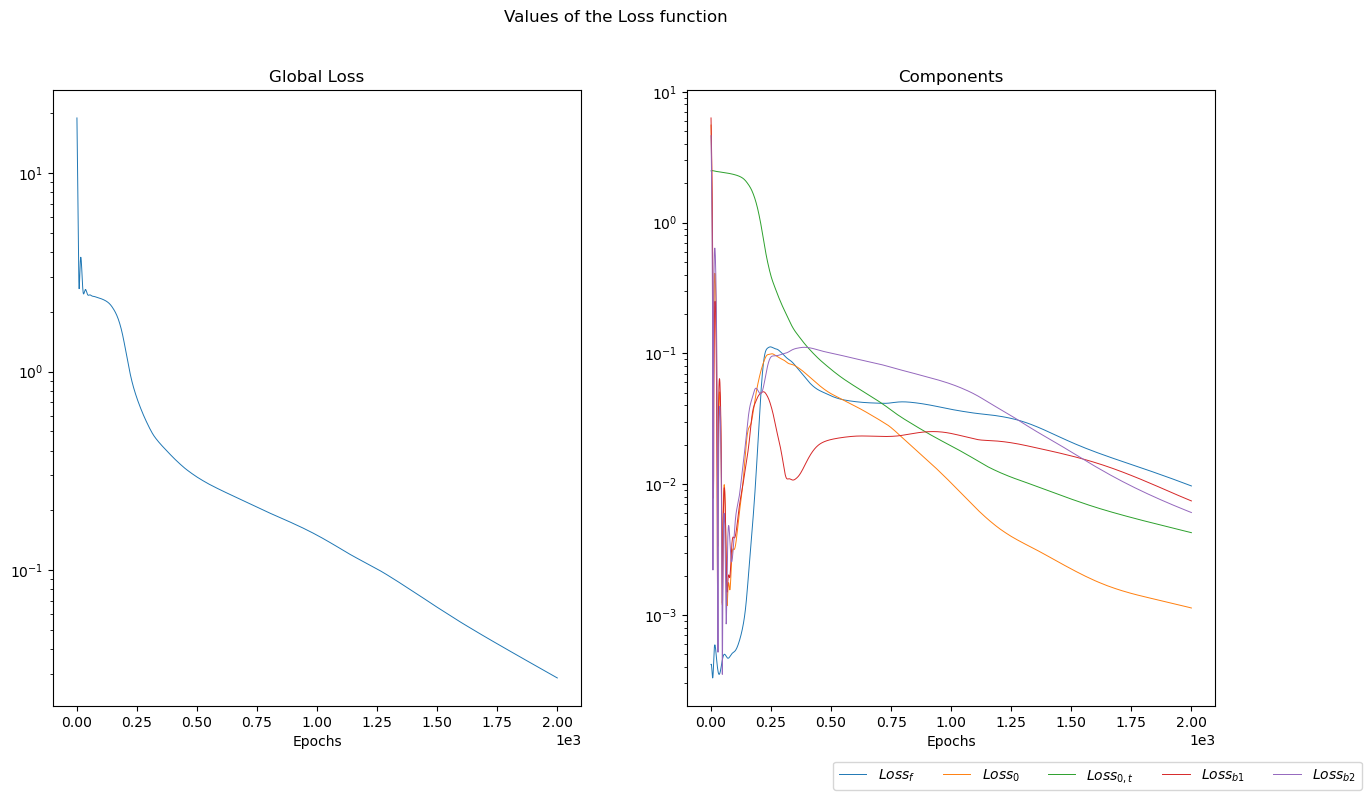

In [13]:
p2 = plt.figure(2, (15, 8))

e = range(n_epochs + 1)
ax1, ax2 = p2.subplots(1, 2)
ax1.semilogy(e, loss_values[:, 0], linewidth=0.7)
ax1.set_title("Global Loss")
ax1.set_xlabel("Epochs")
ax1.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

# plt.ylabel('Loss values')
ax2.semilogy(e, loss_values[:, 1], linewidth=0.7, label="$Loss_f$")
ax2.semilogy(e, loss_values[:, 2], linewidth=0.7, label="$Loss_0$")
ax2.semilogy(e, loss_values[:, 3], linewidth=0.7, label="$Loss_{0,t}$")
ax2.semilogy(e, loss_values[:, 4], linewidth=0.7, label="$Loss_{b1}$")
ax2.semilogy(e, loss_values[:, 5], linewidth=0.7, label="$Loss_{b2}$")
ax2.set_xlabel("Epochs")
ax2.set_title("Components")
ax2.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
p2.legend(loc="lower right", ncol=5)

plt.suptitle("Values of the Loss function")
plt.show()

Compare the exact solution with the PINN prediction and evaluate the point-wise error

In [14]:
with torch.inference_mode():
    # Get the model's prediction
    U_theta = convert(eval_on_xt(FNN, XT[:, 0:1], XT[:, 1:2]))
    # Reshape U_theta to have the same structure as your grid
    U_theta = U_theta.reshape(x_grid.shape)
    u_ex_tst = convert(u_ex(x_grid, t_grid))
    x_grid = convert(x_grid)
    t_grid = convert(t_grid)


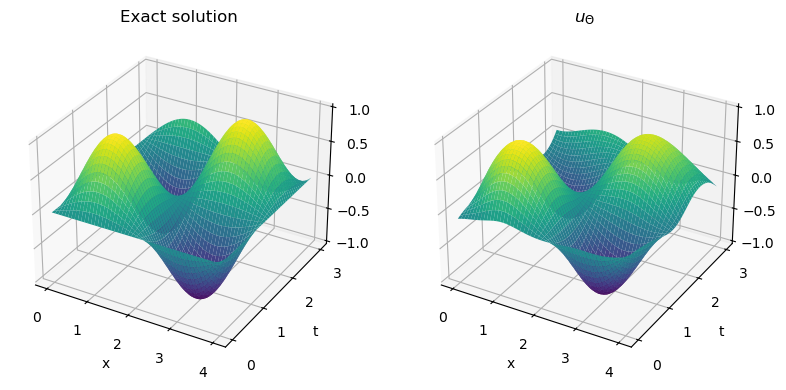

In [15]:
# Plot the surface
p3 = plt.figure(3, figsize=plt.figaspect(0.5))

ax = p3.add_subplot(1, 2, 1, projection="3d")
ax.plot_surface(x_grid, t_grid, u_ex_tst, cmap="viridis")
ax.set_title("Exact solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.yaxis.set_ticks(np.arange(t_ini, t_fin + 1, 1))
ax.zaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax = p3.add_subplot(1, 2, 2, projection="3d")
ax.plot_surface(x_grid, t_grid, U_theta, cmap="viridis")
ax.set_title(r"$u_{\Theta}$")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.yaxis.set_ticks(np.arange(t_ini, t_fin + 1, 1))
ax.zaxis.set_ticks(np.arange(-1, 1.5, 0.5))
plt.show()

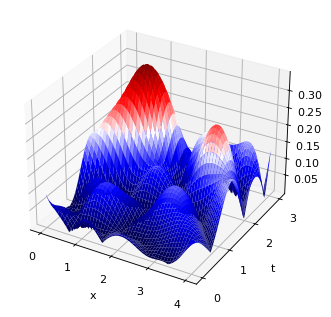

In [16]:
# 3D

p4 = plt.figure(4, dpi=80)
ax = p4.subplots(subplot_kw={"projection": "3d"})
ax.xaxis.set_ticks(np.arange(x_ini, x_fin + 1, 1))
ax.yaxis.set_ticks(np.arange(t_ini, t_fin + 1, 1))
ax.plot_surface(x_grid, t_grid, np.abs(U_theta - u_ex_tst), cmap="seismic")
ax.set_xlabel("x")
ax.set_ylabel("t")

ax.ticklabel_format(style="sci", axis="z", useMathText=True, scilimits=(-5, 6))


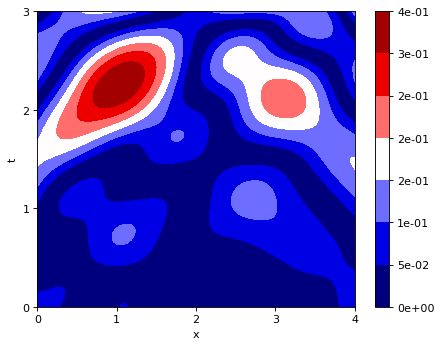

In [17]:
# 2D
p5 = plt.figure(5, dpi=80)

plt.contourf(x_grid, t_grid, np.abs(U_theta - u_ex_tst), cmap="seismic")
plt.xticks(np.arange(x_ini, x_fin + 1, 1))
plt.yticks(np.arange(t_ini, t_fin + 1, 1))
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar(format="%.0e")

$L^2$ Errors

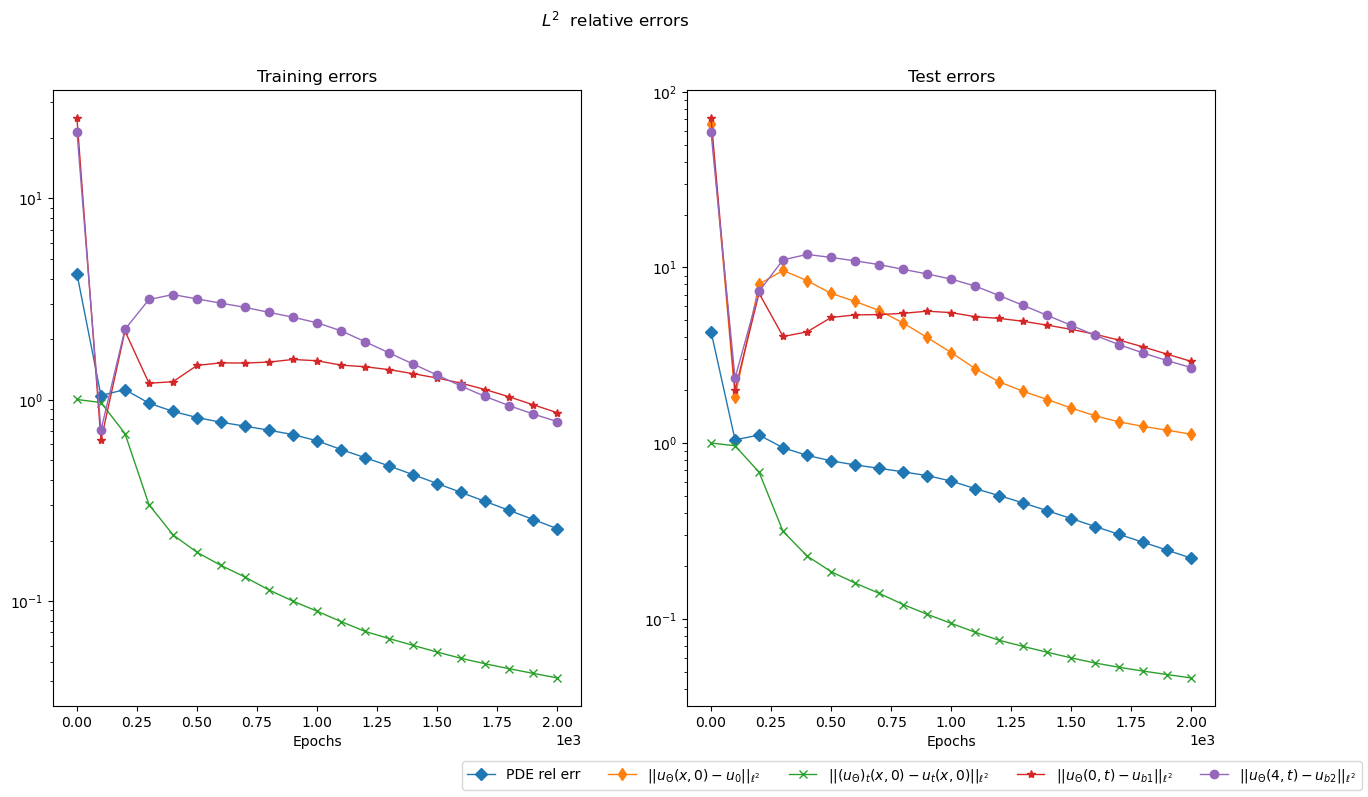

In [18]:
p6 = plt.figure(6, figsize=(15, 8))
p6.suptitle("$L^2$  relative errors")
ax1, ax2 = p6.subplots(1, 2)
E = np.arange(0, n_epochs + 1, STEP)
ax1.semilogy(E, err_tr[:, 0], marker="D", linewidth=1, label="PDE rel err")
ax1.semilogy(
    E,
    err_tr[:, 1],
    marker="d",
    linewidth=1,
    label=r"$||u_{\Theta}(x,0) - u_0||_{\ell^2}$",
)
ax1.semilogy(
    E,
    err_tr[:, 2],
    marker="x",
    linewidth=1,
    label=r"$||(u_{\Theta})_t(x,0) - u_t(x,0)||_{\ell^2}$",
)
ax1.semilogy(
    E,
    err_tr[:, 3],
    marker="*",
    linewidth=1,
    label=r"$||u_{\Theta}(0,t)-u_{b1}||_{\ell^2}$",
)
ax1.semilogy(
    E,
    err_tr[:, 4],
    marker="o",
    linewidth=1,
    label=r"$||u_{\Theta}(4,t)-u_{b2}||_{\ell^2}$",
)
ax1.set_xlabel("Epochs")
ax1.set_title("Training errors")
ax1.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

ax2.semilogy(E, err_tst[:, 0], marker="D", linewidth=1)
ax2.semilogy(E, err_tst[:, 1], marker="d", linewidth=1)
ax2.semilogy(E, err_tst[:, 2], marker="x", linewidth=1)
ax2.semilogy(E, err_tst[:, 3], marker="*", linewidth=1)
ax2.semilogy(E, err_tst[:, 4], marker="o", linewidth=1)
ax2.set_xlabel("Epochs")
ax2.set_title("Test errors")
p6.legend(loc="lower right", ncol=5)
ax2.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
plt.show()

Animation of the solution during training 

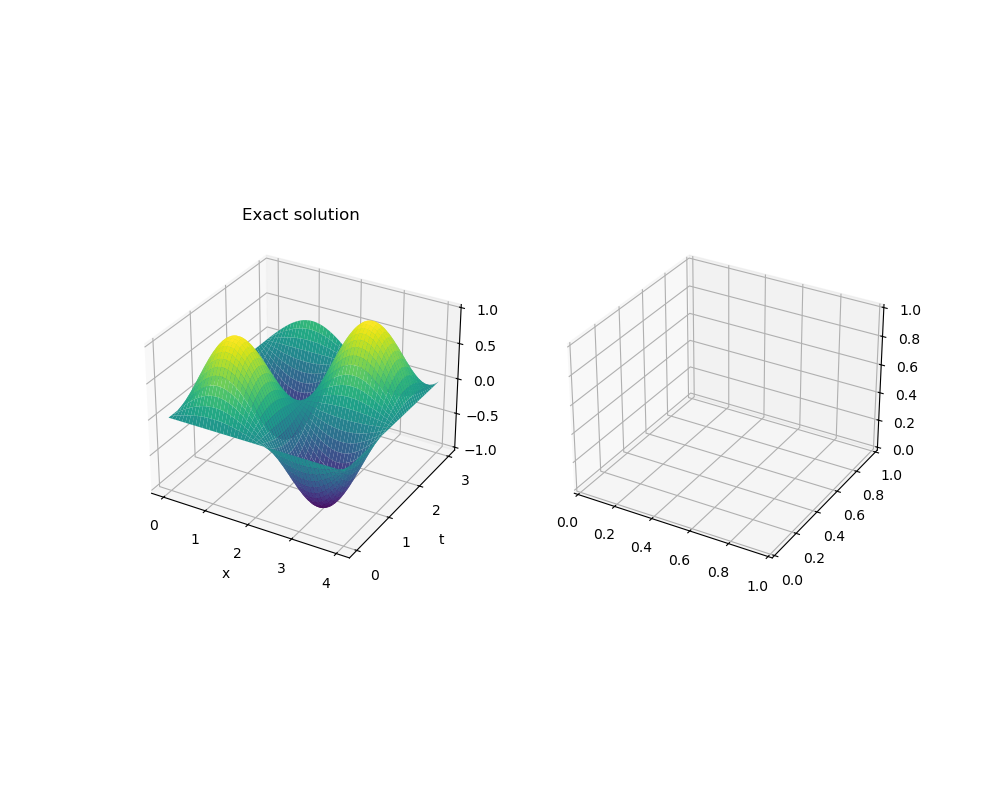

In [19]:
%matplotlib widget
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(10, 8), subplot_kw={"projection": "3d"})

axs1.plot_surface(x_grid, t_grid, u_ex_tst, cmap="viridis")
axs1.set_title("Exact solution")
axs1.set_xlabel("x")
axs1.set_ylabel("t")
axs1.set_xticks(np.arange(0, x_fin + 1, 1))
axs1.set_yticks(np.arange(0, t_fin + 1, 1))
axs1.zaxis.set_ticks(np.arange(-1, 1.5, 0.5))


def updata_data(frame):
    U_animate = u_animate[frame, :].reshape(x_grid.shape)
    axs2.clear()
    axs2.plot_surface(x_grid, t_grid, U_animate, cmap="viridis")
    axs2.set_xlabel("x")
    axs2.set_ylabel("t")
    axs2.set_title(r"$u_{\Theta}$")
    axs2.grid("on")
    axs2.zlim([-1, 1])
    plt.suptitle(f"Epoch {frame*STEP}")
    return axs2


animation = FuncAnimation(fig, func=updata_data, frames=len(u_animate), interval=5)
plt.show()
# for google colab
# from IPython.display import HTML
# video = HTML(anim.to_html5_video())
# display(video)
# plt.close()